In [1]:
!git clone https://github.com/shivigup/sunspots

Cloning into 'sunspots'...
remote: Enumerating objects: 17, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 17 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (17/17), done.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import pandas as pd

In [4]:
df = pd.read_csv("sunspots/data/Sunspots.csv")
df.drop(df.columns[df.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
df['Date'] = pd.to_datetime(df['Date'])

In [5]:
time = df['Date']
series = df['Monthly Mean Total Sunspot Number']
split_time = 2500
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [17]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    #plt.grid(True)

In [ ]:
series = series.to_numpy()

In [29]:
window_size = 12
batch_size = 32
shuffle_buffer_size = 1000

In [30]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [31]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(dataset)

<PrefetchDataset shapes: ((None, None), (None,)), types: (tf.float64, tf.float64)>


Single layer neural network

In [24]:

l0 = tf.keras.layers.Dense(1, input_shape=[window_size])
model = tf.keras.models.Sequential([l0])


model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9))
model.fit(dataset,epochs=100,verbose=1)

print("Layer weights {}".format(l0.get_weights()))

<PrefetchDataset shapes: ((None, None), (None,)), types: (tf.float64, tf.float64)>
Epoch 1/100
74/74 [==============================] - 1s 5ms/step - loss: 30731.1016
Epoch 2/100
74/74 [==============================] - 1s 5ms/step - loss: 18532.9688
Epoch 3/100
74/74 [==============================] - 1s 5ms/step - loss: 5418.9956
Epoch 4/100
74/74 [==============================] - 1s 6ms/step - loss: 1773.7048
Epoch 5/100
74/74 [==============================] - 1s 5ms/step - loss: 2366.4480
Epoch 6/100
74/74 [==============================] - 1s 5ms/step - loss: 1085.3606
Epoch 7/100
74/74 [==============================] - 1s 5ms/step - loss: 2068.3496
Epoch 8/100
74/74 [==============================] - 1s 5ms/step - loss: 1246.4957
Epoch 9/100
74/74 [==============================] - 1s 6ms/step - loss: 1390.6621
Epoch 10/100
74/74 [==============================] - 1s 5ms/step - loss: 1152.7811
Epoch 11/100
74/74 [==============================] - 1s 5ms/step - loss: 2541.5730


In [26]:
forecast = []

for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:(time + window_size)][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

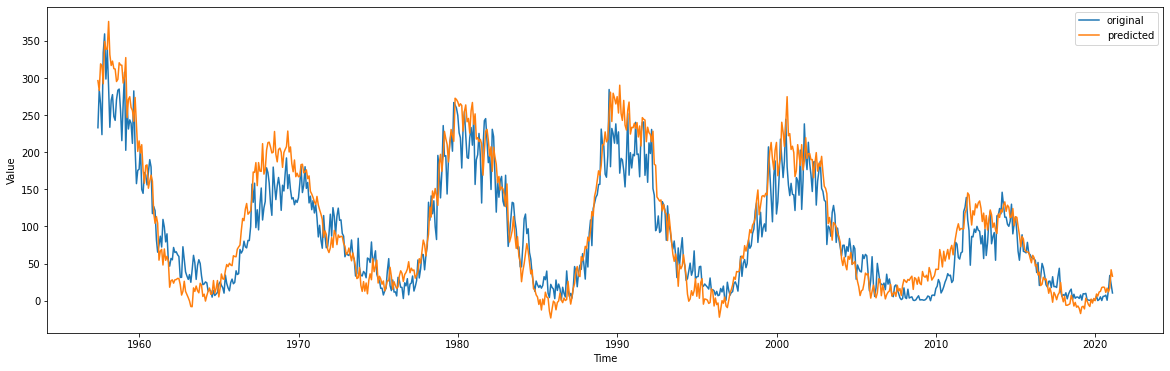

In [27]:
plt.figure(figsize=(20, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)
plt.legend(["original", "predicted"])
plt.savefig("NN_1_layer.png")
plt.show()

In [28]:
print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

1089.1273
25.32275


Multi layer neural network 

In [46]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9))
model.fit(dataset,epochs=100,verbose=1)

Epoch 1/100
78/78 [==============================] - 1s 4ms/step - loss: 1101.2004
Epoch 2/100
78/78 [==============================] - 0s 3ms/step - loss: 775.9364
Epoch 3/100
78/78 [==============================] - 0s 3ms/step - loss: 739.5057
Epoch 4/100
78/78 [==============================] - 0s 3ms/step - loss: 716.8882
Epoch 5/100
78/78 [==============================] - 0s 4ms/step - loss: 741.0974
Epoch 6/100
78/78 [==============================] - 0s 3ms/step - loss: 694.7513
Epoch 7/100
78/78 [==============================] - 0s 3ms/step - loss: 722.8719
Epoch 8/100
78/78 [==============================] - 0s 3ms/step - loss: 672.0325
Epoch 9/100
78/78 [==============================] - 0s 3ms/step - loss: 683.4713
Epoch 10/100
78/78 [==============================] - 0s 3ms/step - loss: 689.9897
Epoch 11/100
78/78 [==============================] - 0s 3ms/step - loss: 685.8323
Epoch 12/100
78/78 [==============================] - 0s 3ms/step - loss: 666.3811
Epoch 13/100

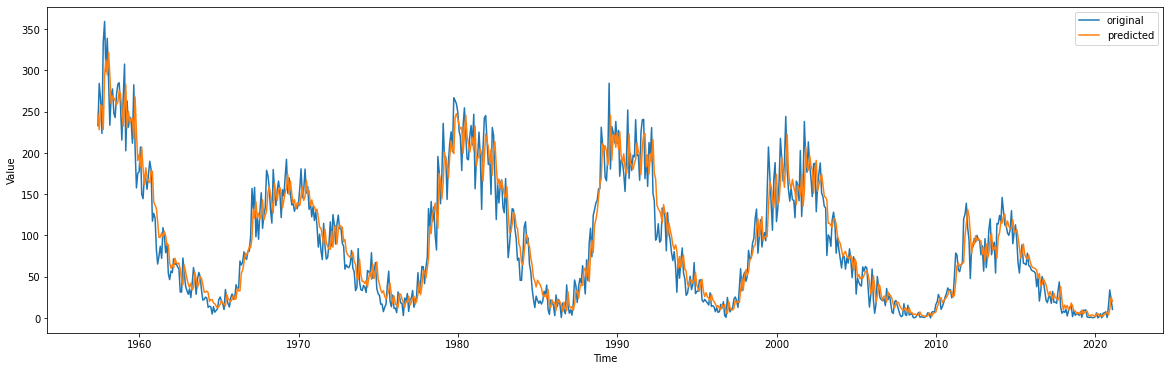

In [47]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(20, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)
plt.legend(["original", "predicted"])
plt.savefig("NN_multi_layer.png")
plt.show()

In [48]:
print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

563.8537
17.257883


In [37]:
#dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule], verbose=1)

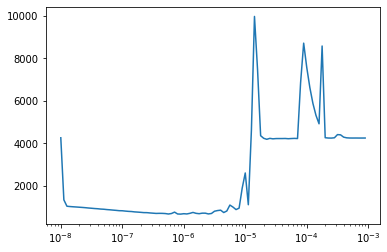

In [40]:
lrs = 1e-8 * (10 ** (np.arange(100) / 20))
plt.semilogx(lrs, history.history["loss"])
#plt.axis([1e-8, 1e-3, 0, 300])

In [41]:
#window_size = 12
#dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.SGD(learning_rate=5e-5, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=500, verbose=0)

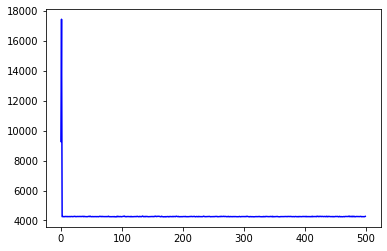

In [42]:
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show()

[4270.45751953125, 4253.5205078125, 4256.81884765625, 4264.65576171875, 4264.71337890625, 4249.51025390625, 4264.3388671875, 4266.38623046875, 4264.73046875, 4254.3740234375, 4262.671875, 4262.0341796875, 4274.09228515625, 4274.3388671875, 4256.0830078125, 4261.63134765625, 4257.29443359375, 4266.91015625, 4263.712890625, 4254.38134765625, 4262.24951171875, 4270.4189453125, 4267.39501953125, 4256.8984375, 4267.6875, 4267.96337890625, 4272.32958984375, 4253.1376953125, 4276.02294921875, 4261.85546875, 4258.62060546875, 4253.28076171875, 4254.4169921875, 4252.20458984375, 4256.26953125, 4267.70556640625, 4276.5283203125, 4258.83642578125, 4284.3125, 4258.43505859375, 4256.08544921875, 4252.16015625, 4264.3359375, 4254.5732421875, 4257.18310546875, 4263.47314453125, 4266.751953125, 4259.44677734375, 4251.9072265625, 4260.6435546875, 4257.25, 4260.75537109375, 4251.45458984375, 4270.0556640625, 4277.16943359375, 4262.43896484375, 4269.0693359375, 4253.5419921875, 4270.1826171875, 4260.7377

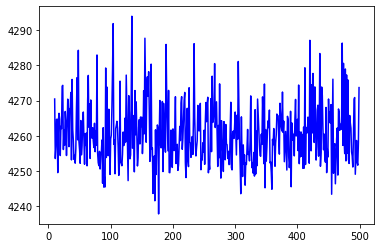

In [43]:
# Plot all but the first 10
loss = history.history['loss']
epochs = range(10, len(loss))
plot_loss = loss[10:]
print(plot_loss)
plt.plot(epochs, plot_loss, 'b', label='Training Loss')
plt.show()

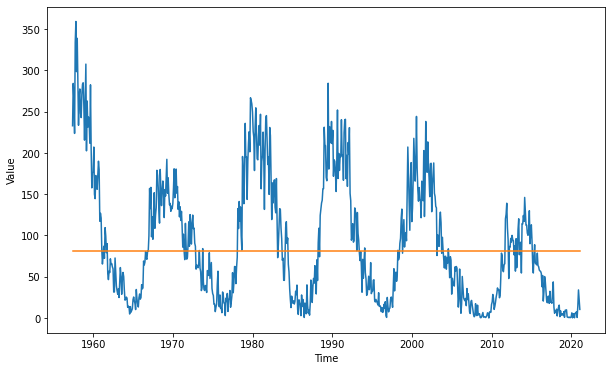

In [44]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [45]:
print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

5780.6562
61.76038
